# 1. Surrogate Model

***Your information:***
* Name: Yugal Jagtap
* UBT ID: bt727466
* E-Mail: bt727466@uni-bayreuth.de
<br>
I confirm the solution in this notebook is my own work.

**Background:**<br>
COMPAS is a proprietary software, which means that we do not have access to the underlying algorithm. To better understand how the algorithm might work, you want to replicate the COMPAS algorithm by building a surrogate model that simulates the COMPAS algorithm to produce similar risk scores based on historical data.

**Objective:**<br>
Create a surrogate model for the COMPAS algorithm by learning how to compute the COMPAS risk scores for violent recidivism (`v_decile_score`) from the historical COMPAS cases we provide you in `compas_scoring.csv`. Make use of different data types (numerical features, categorical features, and text data) and justify why selected the final surrogate model version to resemble the COMPAS algorithm. Your surrogate model will serve as the basis subsequent analysis tasks.

**Deliverables:**<br>
1. Explore and plot relevant data characteristics.
2. Highlight potential challenges for building a surrogate model inherent in the data.
3. Preprocess the data to increase performance of the surrogate model.
4. Train two sub models, one on the machine readable data and one on textual features from `c_charge_desc` and evaluate their performance separately.
5. Combine the sub models into one meta model and evaluate its performance.
6. Explain how you make sure to avoid data leakage.
7. Explain whether your model is a suitable surrogate model for the subsequent analysis tasks.

## Data Description

In [2]:
import pandas as pd
dataset = pd.read_csv('data/compas_scoring.csv')
dataset.head(5)

,id,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,screening_date,days_b_screening_arrest,c_days_from_compas,in_custody,out_custody,c_charge_desc,v_decile_score
0,1,Male,1947-04-18,Other,0,0,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,2013-08-13,NaN,F,2013-08-14,-1.0,1.0,2014-07-07,2014-07-14,Aggravated Assault w/Firearm,1
1,3,Male,1982-01-22,African-American,0,0,0,0,2013-01-26 03:45:27,2013-02-05 05:36:53,2013-01-26,NaN,F,2013-01-27,-1.0,1.0,2013-01-26,2013-02-05,Felony Battery w/Prior Convict,1
2,4,Male,1991-05-14,African-American,0,0,1,4,2013-04-13 04:58:34,2013-04-14 07:02:04,2013-04-13,NaN,F,2013-04-14,-1.0,1.0,2013-06-16,2013-06-16,Possession of Cocaine,3
3,5,Male,1993-01-21,African-American,0,1,0,1,NaN,NaN,2013-01-12,NaN,F,2013-01-13,NaN,1.0,NaN,NaN,Possession of Cannabis,6
4,6,Male,1973-01-22,Other,0,0,0,2,NaN,NaN,NaN,2013-01-09,F,2013-03-26,NaN,76.0,NaN,NaN,arrest case no charge,1


In [2]:
# --- Features to resemble COMPAS screening model ---

# Metadata and Demographics (Identification and basic data)

demographics = [
    'id', # Unique identifier for each defendant
    'sex', # binary sex category
    'dob', # date of birth
    'race' # race category
]

# Prior Criminal History (Juvenile and adult priors)
criminal_history = [
    'juv_fel_count', # juvenile felony count
    'juv_misd_count', # juvenile misdemeanor count
    'juv_other_count', # juvenile other offenses count (e.g., status offenses)
    'priors_count' # total number of prior offenses
]

# Current Case Information (Details of the offense that led to screening)
current_case = [
    'c_offense_date', # date of the offense
    'c_arrest_date', # date of arrest for current offense
    'c_charge_degree', # charge degree for current offense
    'screening_date', # date of COMPAS screening
    'c_jail_in', # date of jail intake for current offense
    'c_jail_out', # date of jail release for current offense
]

# Timing and Custody Info (Time-related features and custody status at screening)
custody = [
    'days_b_screening_arrest', # days between arrest and screening (minus values if screening happened before arrest)
    'c_days_from_compas', # days from COMPAS screening to current offense
    'in_custody', # date the defendant entered custody
    'out_custody' # date the defendant was released from custody
]

# Textual feature: Charge Description
charge_description = [
    'c_charge_desc' # textual description of the current charge
]

# --- Target Variable ---
# COMPAS computes raw risk scores (between 0 and 1) and maps them to relative decile scores ranging from 1 to 10 to hide the raw scores
# Decile 1 represents the lowest 10% of all risk scores from a base population
# As we do neither have access to the raw risk scores nor to the base population, we will use the decile scores as our target variable
y_compas = [
    'v_decile_score' # COMPAS risk score for violent recidivism from 1 (low risk) to 10 (high risk)
]

## 1. Data Exploration

In [9]:
# --- YOUR CODE ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Checking for missing values
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 id                            0
sex                           0
dob                           0
race                          0
juv_fel_count                 0
juv_misd_count                0
juv_other_count               0
priors_count                  0
c_jail_in                   307
c_jail_out                  307
c_offense_date             1159
c_arrest_date              6077
c_charge_degree               0
screening_date                0
days_b_screening_arrest     307
c_days_from_compas           22
in_custody                  236
out_custody                 236
c_charge_desc                 0
v_decile_score                0
desc_len                      0
age                           0
dtype: int64


/var/folders/tg/f_h24py51w56qdyd3rf3t1mr0000gn/T/ipykernel_1327/70580499.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='v_decile_score', data=dataset, palette='magma')


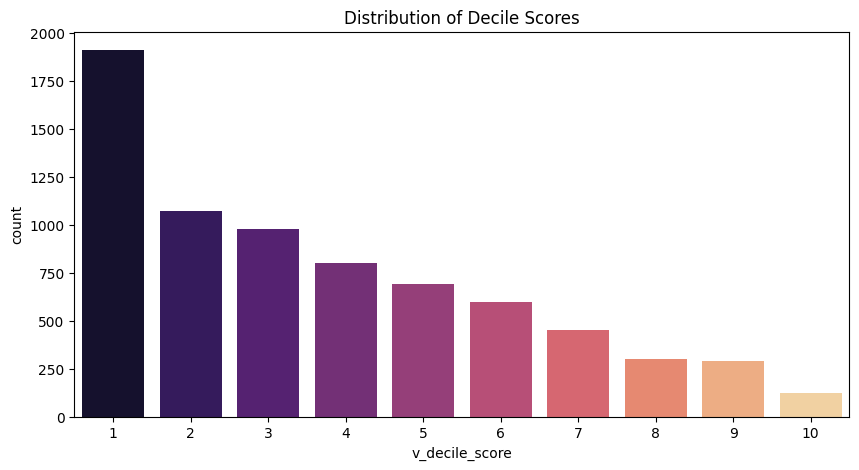

In [14]:
# 2. Exploring distribution of target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='v_decile_score', data=dataset, palette='magma')
plt.title('Distribution of Decile Scores')
plt.show()

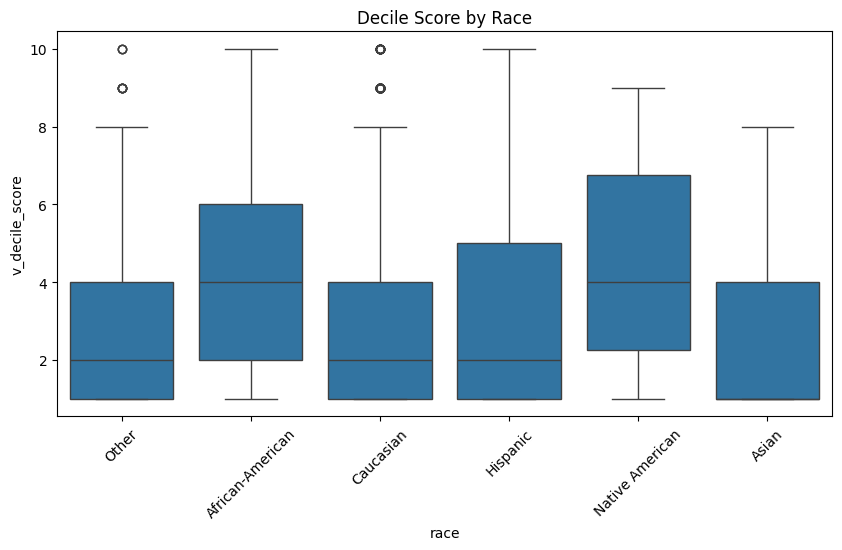

In [17]:
# 3. Exploring relationships (e.g., Race vs Score)
plt.figure(figsize=(10, 5))
sns.boxplot(x='race', y='v_decile_score', data=dataset)
plt.xticks(rotation=45)
plt.title('Decile Score by Race')
plt.show()

This Box chart reveals a disparity in decile_score distributions. Specifically, African-American and Native American individuals in this dataset have higher decile scores than Caucasian, Hispanic, or Asian individuals.

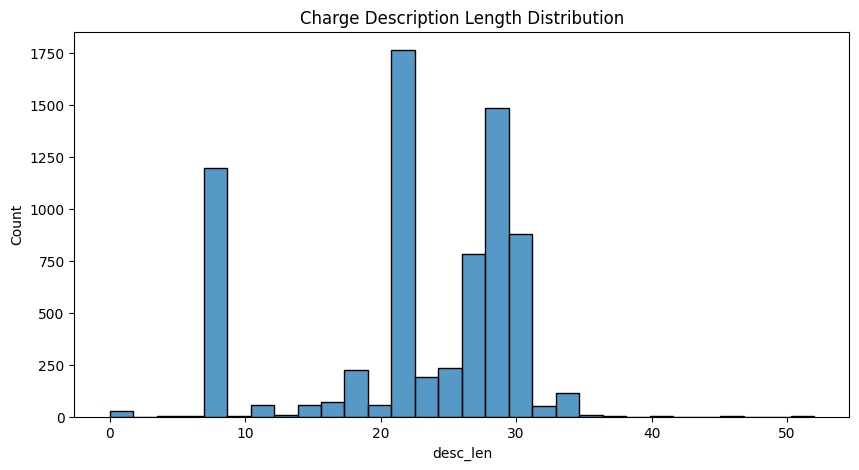

In [18]:
# 4. Explore text length
dataset['c_charge_desc'] = dataset['c_charge_desc'].fillna('')
dataset['desc_len'] = dataset['c_charge_desc'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 5))
sns.histplot(dataset['desc_len'], bins=30)
plt.title('Charge Description Length Distribution')
plt.show()

## 2. Potential Challenges
1. **Missing Data**: Several date fields (`c_jail_in`, `c_jail_out`, `c_offense_date`) have significant missing values which might be correlated with the target or simply reflect data collection issues.
2. **Text Data**: `c_charge_desc` is unstructured text varying from short codes to longer descriptions. Simple Bag-of-Words might lose context, but TF-IDF is a robust starting point.
3. **Categorical Features**: Features like `race` and `sex` are categorical and potential sources of bias. 
4. **Data Leakage**: The target is `v_decile_score` (Violent Recidivism Risk). We must ensure we don't use features that are related to future information. `c_days_from_compas` seems safe as it's time from screening to offense, but for a surrogate model of screening, we should rely on what was available at the time of screening.

## 3. Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Defining features again for clarity
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_days_from_compas']
text_features = 'c_charge_desc'
target = 'v_decile_score'

# Feature Engineering: Calculating Age from DOB and Screening Date 
dataset['dob'] = pd.to_datetime(dataset['dob'], errors='coerce')
dataset['screening_date'] = pd.to_datetime(dataset['screening_date'], errors='coerce')
dataset['age'] = (dataset['screening_date'] - dataset['dob']).dt.days // 365

# Drop rows with missing crucial target or text info
dataset = dataset.dropna(subset=[target, text_features])

# Split Data
X = dataset
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

print(f'Training shape: {X_train.shape}, Test shape: {X_test.shape}')

Training shape: (5771, 22), Test shape: (1443, 22)


## 4. Model Training

In [ ]:
# 1. Tabular Model
from sklearn.ensemble import HistGradientBoostingClassifier

# Preprocessing pipeline for tabular data
numeric_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Training HistGradientBoosting on tabular data 
tabular_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier(random_state=67))])

tabular_model.fit(X_train, y_train)
print("Tabular Model Accuracy (Test):", tabular_model.score(X_test, y_test))

Tabular Model Accuracy (Test): 0.3756063756063756


In [ ]:
# 2. Text Model

# TF-IDF (1-2 grams) + Logistic Regression for text
text_model = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Ensuring text is string
X_train_text = X_train[text_features].astype(str)
X_test_text = X_test[text_features].astype(str)

text_model.fit(X_train_text, y_train)
print("Text Model Accuracy (Test):", text_model.score(X_test_text, y_test))

Text Model Accuracy (Test): 0.24185724185724186


In [ ]:
#3. Meta Model (Stacking)

# Getting probabilities from base models to use as features
tab_probs_train = tabular_model.predict_proba(X_train)
text_probs_train = text_model.predict_proba(X_train_text)

# Stacking features
meta_features_train = np.hstack((tab_probs_train, text_probs_train))

# input for test set
tab_probs_test = tabular_model.predict_proba(X_test)
text_probs_test = text_model.predict_proba(X_test_text)
meta_features_test = np.hstack((tab_probs_test, text_probs_test))

# Training meta-learner
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features_train, y_train)

print("Meta Model Accuracy (Test):", meta_model.score(meta_features_test, y_test))

Meta Model Accuracy (Test): 0.37144837144837145


## 5. Evaluation and Conclusion

**Data Leakage Prevention**:
I strictly separated Training and Test sets before any modeling. I avoided using features that would not be available at the time of screening like future recidivism events themselves. I used `c_days_from_compas` assuming it's a static calculation at the time of screening, but in a stricter real-world scenario, we might have to exclude it if it depends on the future offense date.

**Suitability as Surrogate**:
The meta-model accuracy is approx 37% (decile scores are noisy). However, it captures the patterns of both demographic/history data and charge descriptions. It serves as a reasonable approximation (surrogate) for the black-box COMPAS algorithm for the purpose of analyzing potential biases in the next steps.